In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

import numpy as np
import pandas as pd
from scipy import signal

In [ ]:
# dt = 0.025
# t = np.arange(0, 20, dt)

# u = 2 + 6*np.cos(2*np.pi*t+0.2) + 10*np.sin(10*np.pi*t + 1.5)
# y = 2 + 5*np.cos(2*np.pi*t) + 7*np.sin(10*np.pi*t + 0.5)+3*np.random.randn(len(t))

# plt.plot(t,u)
# plt.plot(t, y)
# plt.show()

In [2]:
pilifer_signal = np.load('./dataFolder/TangentErrorAngle_smoothened.npy')

In [3]:
trackPoints = pd.read_csv('./dataFolder/MV_m1_points.csv')
trackPoints.head()

,body_X,body_Y,nectary_X,nectary_Y,prob_base_X,prob_base_Y,prob_mid_X,prob_mid_Y,prob_1_X,prob_1_Y,prob_2_X,prob_2_Y,prob_3_X,prob_3_Y,prob_4_X,prob_4_Y,prob_5_X,prob_5_Y
0,388.078376,381.614068,372.227746,188.424715,381.619192,323.795071,380.238266,277.537139,381.059690,314.190856,381.198874,307.238159,381.084916,300.212757,380.799242,293.442655,380.405303,287.157793
1,386.810000,386.980000,372.970000,188.000000,381.348241,327.728714,379.416841,278.019424,380.405303,320.557345,380.743042,310.449771,380.743042,302.621466,380.306818,295.597465,380.208333,288.594333
2,383.100000,379.100000,373.950000,188.010000,378.548415,321.217857,379.950000,278.000000,378.337121,315.709023,378.463881,309.847593,378.691797,301.216386,379.125000,295.238330,379.223485,286.080388
3,379.238602,381.156274,374.930000,188.010000,377.155303,323.250858,376.815665,278.019424,377.226377,314.914284,378.008049,309.245416,377.096385,301.216386,377.253788,295.597465,376.859848,287.696495
4,378.700000,379.270000,374.940000,188.010000,376.495312,316.354012,377.010000,278.000000,377.363281,312.985141,376.640553,306.635981,376.754511,300.614209,376.465909,294.699627,376.958333,287.157793


In [4]:
body_lateral = trackPoints.loc[:,'body_X'].values
nectary_lateral = trackPoints.loc[:,'nectary_X'].values

In [5]:
pilifer_signal = pilifer_signal[:-1]

In [6]:
len(body_lateral), len(nectary_lateral), len(pilifer_signal)

(1000, 1000, 1000)

In [7]:
framerate = 100
dt = 1/framerate

C:\Users\tanvi.deora\AppData\Local\anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


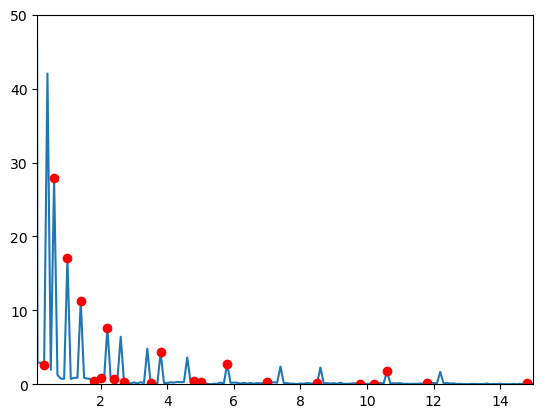

In [8]:
y_fft = np.fft.fft(nectary_lateral, norm = 'forward')
freq = np.fft.fftfreq(len(y_fft), dt)

fidx = freq>=0
freq=freq[fidx]
y_fft = y_fft[fidx]

y_fft[1:]*=2

plt.plot(freq, np.abs(y_fft))
plt.xlim(0.1,15)
plt.ylim(0, 50)

thresh = 1.5
freqs = signal.find_peaks(y_fft, threshold = 0.1)[0]
# np.where(np.abs(y_fft)>=thresh)
plt.plot(freq[freqs], np.abs(y_fft[freqs]), 'or')



plt.show()

In [ ]:
def half_fft(y, t = None, dt = None):
    """
    Compute the one-sided FFT of a signal.

    Parameters:
        y (numpy.ndarray): The input signal in time domain.
        t (numpy.ndarray, optional): The time array corresponding to the signal. If not provided, `dt` must be specified.
        dt (float, optional): The time step (1/sample rate). If not provided, it will be calculated from `t`.

    Returns:
        tuple: A tuple containing:
            - y_fft (numpy.ndarray): The one-sided FFT of the input signal.
            - freq (numpy.ndarray): The corresponding frequency array.

    Notes:
        - If both `t` and `dt` are not provided, the function will return `None` and print an error message.
        - The FFT is normalized using the 'forward' norm, and the amplitudes are doubled for non-DC components.
    """
    
    if dt is None:
        try:
            dt = np.mean(np.diff(t))
        except:
            print('You must either provide an array of times or a dt (1/sample rate).')
            return None
    
    y_fft = np.fft.fft(y, norm = 'forward')
    freq = np.fft.fftfreq(len(y_fft), dt)

    fidx = freq>=0
    freq=freq[fidx]
    y_fft = y_fft[fidx]
    y_fft[1:]*=2
    
    return y_fft, freq  
     
def plotBode(u, y, t=None, dt=None, freqs = None, u_thresh = None, ax=None, **kwargs):
    
    u_fft,freq = half_fft(u, t=t, dt=dt)
    y_fft,freq = half_fft(y, t=t, dt=dt)
    
    if u_thresh is not None:
        freq_idx = [np.where(np.abs(u_fft)>=u_thresh)]
        u_fft = u_fft[freq_idx]
        y_fft = y_fft[freq_idx]
        freq = freq[freq_idx]
        
    if freqs is not None:
        freq_idx = [np.where(np.round(freq, decimals=1) == f) for f in freqs]
        
        u_fft = u_fft[freq_idx]
        y_fft = y_fft[freq_idx]
        freq = freq[freq_idx]
    
    tf = y_fft/u_fft

    freq = freq.flatten()
    mag = np.abs(tf).flatten()
    phase = np.angle(tf).flatten()
    
    if ax is None:
        fig, ax = makeBodeAxes()
    
    ax[0].plot(freq, mag, **kwargs)
    ax[1].plot(freq, phase, **kwargs)
    
    return fig, ax
    
    
def makeBodeAxes(magUnit = 'abs', figsize = (8, 8), angleUnit = 'deg', angleWrap = True):
    fig, ax = plt.subplots(2,1, figsize = figsize, 
                           gridspec_kw = {'hspace':0.05},
                           sharex = True)
    
    ax[0].set_yscale('log', base=10)
    ax[0].set_ylabel('Gain')
    
    ax[1].set_xscale('log', base=10)
    ax[1].set_ylim([-np.pi, np.pi])
    
    ax[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    
    if angleUnit == 'deg':
        tick_labels = ['-180', '-90', '0', '90', '180']
    # elif angleUnit == 'rad':
    #     tick_labels = [r'-\pi', r'-\frac{\pi}{2}', r'0', r'-\frac{\pi}{2}', r'-\pi']
    
    ax[1].set_yticklabels(tick_labels)
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel(f'Phase ({angleUnit})')
    
    return fig, ax

In [ ]:
fig, ax = plotBode(u = nectary_lateral, y = body_lateral, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.1
                   , marker = '.', linestyle = '--')
ax[0].set_ylim([0.1, 20])
plt.show()

In [ ]:
fig, ax = plotBode(u = nectary_lateral, y = pilifer_signal, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.01
                   , marker = '.', linestyle = '--')
# ax[0].set_ylim([0.1, 1.1])
plt.show()

In [ ]:
fig, ax = plotBode(u = pilifer_signal, y = body_lateral, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.01
                   , marker = '.', linestyle = '--')
# ax[0].set_ylim([0.1, 1.1])
plt.show()

In [ ]:
freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7]

In [ ]:
freq_idx = [np.where(np.round(freq, decimals=1) == f) for f in freqs]
freq_idx

In [ ]:
for f in freqs:
    print(f)
    print(np.where(np.round(freq, decimals=1) == f))